In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Resampling Methods

Resampling is the process of repeatedly **drawing subsamples** from a training dataset, and fitting a model to each sample with the goal of discovering additional properties or information about the model. For example, in a regression modeling context, we can fit a particular regression model to each sample, and observe **how the fits vary** among the samples. 

We will introduce two important resampling methods:

* cross-validation
* bootstrapping

Both have important uses in statistical and machine learning applications, particularly for **assessing** models, performing model **selection**, and estimating the **precision** of parameter estimates.

## Cross-validation

One approach for evaluating the fit of a particular model is to divide the available dataset into two parts and:

* use one subset to fit the model
* used the other subset to test the model

What do we mean by "test"? If the model fit is a good one, then providing new data to the model should generate predicted outputs that are close to the observed outputs. This can be quantified by calculating the **test error**.  

/usr/local/lib/python3.4/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


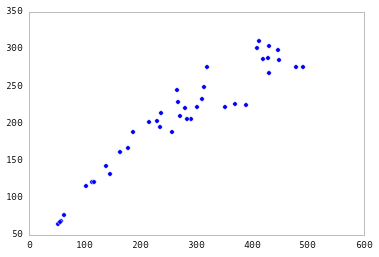

In [6]:
salmon = pd.read_table("../data/salmon.dat", sep='\s*', index_col=0)
plt.scatter(x=salmon.spawners, y=salmon.recruits)

On the one extreme, a linear relationship is underfit; on the other, we see that including a very large number of polynomial terms is clearly overfitting the data.

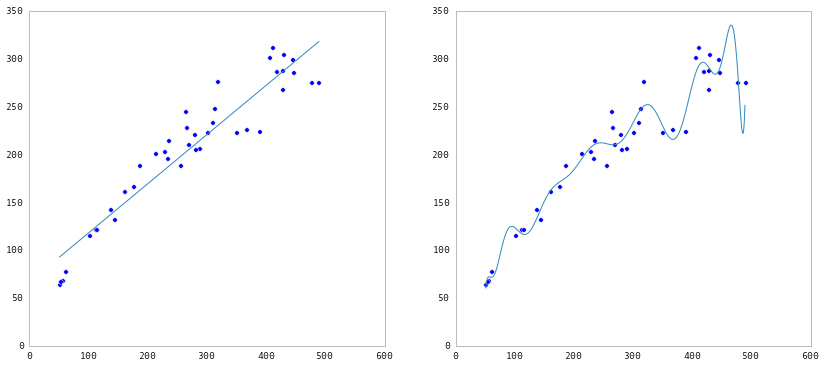

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

xvals = np.arange(salmon.spawners.min(), salmon.spawners.max())

fit1 = np.polyfit(salmon.spawners, salmon.recruits, 1)
p1 = np.poly1d(fit1)
axes[0].plot(xvals, p1(xvals))
axes[0].scatter(x=salmon.spawners, y=salmon.recruits)

fit15 = np.polyfit(salmon.spawners, salmon.recruits, 15)
p15 = np.poly1d(fit15)
axes[1].plot(xvals, p15(xvals))
axes[1].scatter(x=salmon.spawners, y=salmon.recruits)

We can select an appropriate polynomial order for the model using **cross-validation**, in which we hold out a testing subset from our dataset, fit the model to the remaining data, and evaluate its performance on the held-out subset.

In [12]:
test_set = salmon.sample(frac=0.3)

In [13]:
train_set = salmon.drop(test_set.index)

A natural criterion to evaluate model performance is root mean square error.

In [14]:
def rmse(x, y, coefs):
    yfit = np.polyval(coefs, x)
    return np.sqrt(np.mean((y - yfit) ** 2))

We can now evaluate the model at varying polynomial degrees, and compare their fit.

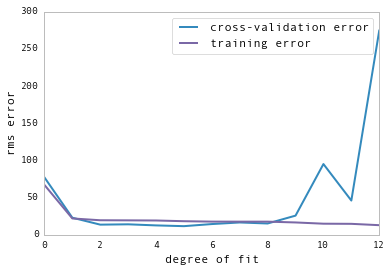

In [15]:
# suppress warnings from Polyfit
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

degrees = np.arange(13)
train_err = np.zeros(len(degrees))
validation_err = np.zeros(len(degrees))

for i, d in enumerate(degrees):
    p = np.polyfit(train_set.spawners, train_set.recruits, d)

    train_err[i] = rmse(train_set.spawners, train_set.recruits, p)
    validation_err[i] = rmse(test_set.spawners, test_set.recruits, p)

fig, ax = plt.subplots()

ax.plot(degrees, validation_err, lw=2, label = 'cross-validation error')
ax.plot(degrees, train_err, lw=2, label = 'training error')

ax.legend(loc=0)
ax.set_xlabel('degree of fit')
ax.set_ylabel('rms error')

In the cross-validation above, notice that the error is high for both very low and very high polynomial values, while training error declines monotonically with degree. The cross-validation error is composed of two components: **bias** and **variance**. When a model is underfit, bias is low but variance is high, while when a model is overfit, the reverse is true.

One can show that the MSE decomposes into a sum of the bias (squared) and variance of the estimator:

$$\begin{aligned}
\text{Var}(\hat{\theta}) &= E[\hat{\theta} - \theta]^2 - (E[\hat{\theta} - \theta])^2 \\
\Rightarrow E[\hat{\theta} - \theta]^2 &= \text{Var}(\hat{\theta}) + \text{Bias}(\hat{\theta})^2
\end{aligned}$$

The training error, on the other hand, does not have this tradeoff; it will always decrease (or at least, never increase) as variables (polynomial terms) are added to the model.

## K-fold Cross-validation

In the example above, our validation was based on just one random split of the data. Try re-running the above example on a different random subset, and examine the result.

There are two issues with this:

1. Your particular random subset may not be representative
2. The fitted model will have higher variance relative to a model fit to the complete dataset

In **k-fold cross-validation**, the training set is split into *k* smaller sets. Then, for each of the k "folds":

1. trained model on *k-1* of the folds as training data
2. validate this model the remaining fold, using an appropriate metric

The performance measure reported by k-fold CV is then the average of the *k* computed values. This approach can be computationally expensive, but does not waste too much data, which is an advantage over having a fixed test subset.

### Example: Cross-validation subsets

Extend the subsetting operation from above to create five random partitions of the dataset.

In [ ]:
# Write your answer here

We can now perform k-fold cross-validation, and report the average error over all of the folds.

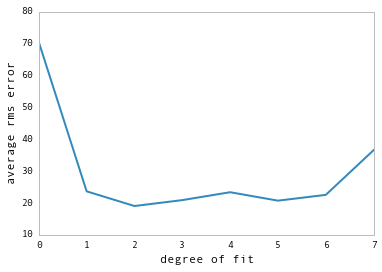

In [21]:
from sklearn.cross_validation import cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

k = 5
degrees = np.arange(8)
k_fold_err = np.empty(len(degrees))

for i, d in enumerate(degrees):
    
    error = np.empty(k)
    
    #for j, fold in enumerate(gen_k_folds(salmon, k)):
    for j, fold in enumerate(KFold(len(salmon), n_folds=k)):

        training, validation = fold
        
        y_train, x_train = salmon.values[training].T
        y_test, x_test = salmon.values[validation].T
        
        p = np.polyfit(x_train, y_train, d)
        
        error[j] = rmse(x_test, y_test, p)

    k_fold_err[i] = error.mean()
        

fig, ax = plt.subplots()

ax.plot(degrees, k_fold_err, lw=2)
ax.set_xlabel('degree of fit')
ax.set_ylabel('average rms error')

# Bootstrapping

Parametric inference can be **non-robust**:

* inaccurate if parametric assumptions are violated
* if we rely on asymptotic results, we may not achieve an acceptable level of accuracy

Parmetric inference can be **difficult**:

* derivation of sampling distribution may not be possible

An alternative is to estimate the sampling distribution of a statistic *empirically* without making assumptions about the form of the population.

We have seen this already with the kernel density estimate.

### Non-parametric Bootstrap

The bootstrap is a resampling method discovered by [Brad Efron](http://www.jstor.org/discover/10.2307/2958830?uid=3739568&uid=2&uid=4&uid=3739256&sid=21102342537691) that allows one to approximate the true sampling distribution of a dataset, and thereby obtain estimates of the mean and variance of the distribution.

Bootstrap sample:

<div style="font-size: 120%;">  
$$S_1^* = \{x_{11}^*, x_{12}^*, \ldots, x_{1n}^*\}$$
</div>

$S_i^*$ is a sample of size $n$, **with** replacement.

In Python, we have already seen sampling. If we want to use NumPy for this, we can permute the column of names to obtain a sample:

In [24]:
titanic = pd.read_excel("../data/titanic.xls", "titanic")

np.random.permutation(titanic.name)[:5]

array(['Gillespie, Mr. William Henry', 'Assam, Mr. Ali',
       'Gill, Mr. John William', 'Compton, Miss. Sara Rebecca',
       'Petranec, Miss. Matilda'], dtype=object)

Sampling is even easier in pandas; `DataFrame` and `Series` objects have `sample` methods that allow for sampling without the need for outside functions.

In [25]:
titanic.name.sample(n=5)

247     Rothschild, Mrs. Martin (Elizabeth L. Barrett)
68                            Chevre, Mr. Paul Romaine
657                             Baclini, Miss. Eugenie
1204                         Sivola, Mr. Antti Wilhelm
1295                               Windelov, Mr. Einar
Name: name, dtype: object

We can use either method to generate a sample *with* replacement, which we can use when bootstrapping.

In [26]:
titanic.name.sample(n=5, replace=True)

150           Harrison, Mr. William
137    Graham, Miss. Margaret Edith
997         Masselmani, Mrs. Fatima
655      Backstrom, Mr. Karl Alfred
918               Kassem, Mr. Fared
Name: name, dtype: object

We regard S as an "estimate" of population P

> population : sample :: sample : bootstrap sample

The idea is to generate replicate bootstrap samples:

<div style="font-size: 120%;">  
$$S^* = \{S_1^*, S_2^*, \ldots, S_R^*\}$$
</div>

Compute statistic $t$ (estimate) for each bootstrap sample:

<div style="font-size: 120%;">  
$$T_i^* = t(S^*)$$
</div>

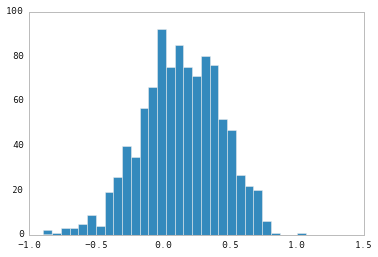

In [27]:
# Sample size
n = 10
# Bootstrap replicates
R = 1000

# Original sample (n=10)
data = np.random.normal(size=n)

# 1000 bootstrap samples of size 10
s = [data[np.random.randint(0,n,n)].mean() for i in range(R)]
_ = plt.hist(s, bins=30)

### Bootstrap Estimates

From our bootstrapped samples, we can extract *estimates* of the expectation and its variance:

$$\bar{T}^* = \hat{E}(T^*) = \frac{\sum_i T_i^*}{R}$$

$$\hat{\text{Var}}(T^*) = \frac{\sum_i (T_i^* - \bar{T}^*)^2}{R-1}$$


In [28]:
boot_mean = np.sum(s)/R
boot_mean

0.13070827047398045

In [29]:
boot_var = ((np.array(s) - boot_mean) ** 2).sum() / (R-1)
boot_var

0.088615646025623135

Since we have estimated the expectation of the bootstrapped statistics, we can estimate the **bias** of T:

$$\hat{B}^* = \bar{T}^* - T$$


In [31]:
boot_mean - np.mean(s)

0.0

### Bootstrap error

There are two sources of error in bootstrap estimates:

1. **Sampling error** from the selection of $S$.
2. **Bootstrap error** from failing to enumerate all possible bootstrap samples.

For the sake of accuracy, it is prudent to choose at least R=1000

### Bootstrap Percentile Intervals

An attractive feature of bootstrap statistics is the ease with which you can obtain an estimate of *uncertainty* for a given statistic. We simply use the empirical quantiles of the bootstrapped statistics to obtain percentiles corresponding to a confidence interval of interest.

This employs the *ordered* bootstrap replicates:

$$T_{(1)}^*, T_{(2)}^*, \ldots, T_{(R)}^*$$

Simply extract the $100(\alpha/2)$ and $100(1-\alpha/2)$ percentiles:

$$T_{[(R+1)\alpha/2]}^* \lt \theta \lt T_{[(R+1)(1-\alpha/2)]}^*$$

In [32]:
s_sorted = np.sort(s)
s_sorted[:10]

array([-0.89375653, -0.84245146, -0.80879621, -0.72252106, -0.71439864,
       -0.70947786, -0.68262221, -0.68068142, -0.64149833, -0.61682725])

In [33]:
s_sorted[-10:]

array([ 0.73578608,  0.73955278,  0.74027992,  0.74903312,  0.75483922,
        0.77256515,  0.77439106,  0.80073271,  0.86940659,  1.06669792])

In [34]:
alpha = 0.05
s_sorted[[(R+1)*alpha/2, (R+1)*(1-alpha/2)]]

array([-0.44942292,  0.68890502])

### Exercise: Cervical dystonia bootstrap estimates

Use bootstrapping to estimate the mean of one of the treatment groups, and calculate percentile intervals for the mean.

In [ ]:
# Write your answer here

# Missing Data

Missing data is a common problem in most real-world scientific datasets. While the best way for dealing with missing data will always be preventing their occurrence in the first place, it usually can't be helped, particularly when data are collected passively or voluntarily, or when data collection and recording is distributed among several people. There are a variety of ways for dealing with missing data, from the very naïve to the very sophisticated, and unfortunately the more common approaches tend to be *ad hoc* and will usually do more harm than good. 

It turns out that more robust methods for imputation are not as difficult to implement as they first appear to be. Two of the best ones are Bayesian imputation and multiple imputation. In this section, we will use multiple imputation to account for missing data in a regression analysis. 

As a motivating example, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes. There is a suite of available predictors, including: 

* gender (`male`)
* number of siblings in the household (`siblings`)
* index of family involvement (`family_inv`)
* whether the primary household language is not English (`non_english`)
* presence of a previous disability (`prev_disab`)
* non-white race (`non_white`)
* age at the time of testing (in months, `age_test`)
* whether hearing loss is not severe (`non_severe_hl`)
* whether the subject's mother obtained a high school diploma or better (`mother_hs`)
* whether the hearing impairment was identified by 3 months of age (`early_ident`).

In [35]:
test_scores = pd.read_csv('../data/test_scores.csv', index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2,2,False,NaN,55,1,NaN,False,False
1,31,1,0,NaN,False,0,53,0,0,False,False
2,83,1,1,1,True,0,52,1,NaN,False,True
3,75,0,3,NaN,False,0,55,0,1,False,False
5,62,0,0,4,False,1,50,0,NaN,False,False


For three variables in the dataset, there are incomplete records.

In [36]:
test_scores.isnull().sum(0)

score             0
male              0
siblings          0
family_inv       33
non_english       0
prev_disab       18
age_test          0
non_severe_hl     0
mother_hs        73
early_ident       0
non_white         0
dtype: int64

## Strategies for dealing with missing data

The easiest (and worst) way to deal with missing data is to ignore it. That is, simply run the analysis, missing values and all, hoping for the best. If your software is any good, this approach will simply not work; the algorithm will try to operate on data that includes missing values, and propagate them, resulting in statistics and estimates that cannot be calculated, which will typically raise errors. If your software is poor, it will make some assumption or decision about the missing values, and proceed to generate  results conditional on the assumption, which creates problems that may never be detected because no indication was given to any potential problem. 

The next easiest (worst) approach to analyzing data with missing values is to conduct list-wise deletion, by deleting the records that have missing values. This is called **complete case analysis**, because only records that are complete get retained for the analysis. The degree to which complete case analysis is undesirable depends on the mechanism by which data have become missing.

## Types of Missingness

- **Missing completely at random (MCAR)**: When data are MCAR, missing cases are, on average, identical to non-missing cases, with respect to the model. Ignoring the missingness will reduce the power of the analysis, but will not bias inference.
- **Missing at random (MAR)**: Missing data depends (usually probabilistically) on measured values, and hence can be modeled by variables observed in the data set. Accounting for the values which “cause” the missing data will produce unbiased results in an analysis.
- **Missing not at random(MNAR)**: Missing data depend on unmeasured or unknown variables. There is no information available to account for the missingness.

The very best-case scenario for using complete case analysis, which corresponds to MCAR missingness, results in a loss of power due to the reduction in sample size. The analysis will lose the information contained in the non-missing elements of a partially-missing record. When data are not missing completely at random, inferences from complete case analysis may be biased due to systematic differences between missing and non-missing records that affects the estimates of key parameters.

One alternative to complete case analysis is to simply fill (*impute*) the missing values with a reasonable guess a the true value, such as the mean, median or modal value of the fully-observed records. This imputation, while not recovering any information regarding the missing value itself for use in the analysis, does provide a mechanism for including the non-missing values in the analysis, thereby making use of all available information.

Performing imputation via mean substitution is easy in Pandas, via the DataFrame/Series `fillna` method.

In [37]:
test_scores.siblings.mean()

1.1256038647342994

In [38]:
test_scores.siblings.fillna(test_scores.siblings.mean())

0      2
1      0
2      1
3      3
5      0
6      1
7      2
9      0
10     0
12     1
13     0
14     2
16     2
17     1
18     1
19     0
21     1
23     1
25     1
26     1
27     1
28     1
29     1
30     2
31     1
32     1
33     2
34     1
35     0
36     1
      ..
194    1
195    1
196    0
198    1
199    1
200    1
201    1
202    3
203    1
204    1
205    0
206    3
207    1
208    1
209    0
210    0
211    0
212    1
213    1
214    2
215    2
216    1
217    1
218    2
219    1
220    2
221    2
222    1
223    2
224    2
Name: siblings, dtype: float64

This approach may be reasonable under the MCAR assumption, but may induce bias under a MAR scenario, whereby missing values may differ systematically relative to non-missing values, making the particular summary statistic used for imputation *biased* as a mean/median/modal value for the missing values.

Beyond this, the use of a single imputed value to stand in place of the actual missing value glosses over the *uncertainty* associated with this guess at the true value. Any subsequent analysis procedure (*e.g.* regression analysis) will behave as if the imputed value were observed, despite the fact that we are actually unsure of the actual value for the missing variable. The practical consequence of this is that the variance of any estimates resulting from the imputed dataset will be artificially reduced.

## Multiple Imputation

One robust alternative to addressing missing data is **multiple imputation** (Schaffer 1999, van Buuren 2012). It produces unbiases parameter estimates, while simultaneously accounting for the uncertainty associated with imputing missing values. It is conceptually and mechanistically straightforward, and produces complete datasets that may be analyzed using any statistical methodology or software one chooses, as if the data had no missing values to begin with.

Multiple imputation generates imputed values based on a regression model. This regression model will help us generate reasonable values, particularly if data are MAR, since it uses information in the dataset that may be informative in predicting what the true value may be. Ideally, we want predictor variables that are correlated with the missing variable, and with the mechanism of missingness, if any. For example, one might be able to use test scores from one subject to predict missing test scores from another; or, the probability of income reporting to be missing may vary systematically according to the education level of the individual.

To see if there is any potential information among the variables in our dataset to use for imputation, it is helpful to calculate the pairwise correlation between all the variables. Since we have discrete variables in our data, the [Spearman rank correlation coefficient](http://www.wikiwand.com/en/Spearman%27s_rank_correlation_coefficient) is appropriate.

In [39]:
test_scores.dropna().corr(method='spearman')

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
score,1.000000,0.073063,-0.085044,-0.539019,-0.278798,-0.184426,0.024057,0.140305,0.228500,0.222711,-0.345061
male,0.073063,1.000000,-0.072006,-0.008714,0.053338,-0.052054,-0.081165,0.031825,0.050372,-0.007690,-0.048638
siblings,-0.085044,-0.072006,1.000000,0.078471,-0.049989,-0.038020,0.104905,-0.003689,0.096268,0.077318,0.006234
family_inv,-0.539019,-0.008714,0.078471,1.000000,0.221696,0.082314,-0.029120,-0.092815,-0.358898,0.006370,0.401617
non_english,-0.278798,0.053338,-0.049989,0.221696,1.000000,-0.021996,0.068095,-0.047775,-0.199639,-0.015812,0.225428
prev_disab,-0.184426,-0.052054,-0.038020,0.082314,-0.021996,1.000000,0.136604,0.048132,0.137893,0.046592,-0.021367
age_test,0.024057,-0.081165,0.104905,-0.029120,0.068095,0.136604,1.000000,-0.122811,0.016760,0.033789,0.068430
non_severe_hl,0.140305,0.031825,-0.003689,-0.092815,-0.047775,0.048132,-0.122811,1.000000,-0.015996,0.008211,0.028480
mother_hs,0.228500,0.050372,0.096268,-0.358898,-0.199639,0.137893,0.016760,-0.015996,1.000000,0.024411,-0.214209
early_ident,0.222711,-0.007690,0.077318,0.006370,-0.015812,0.046592,0.033789,0.008211,0.024411,1.000000,-0.022854


We will try to impute missing values the mother's high school education indicator variable, which takes values of 0 for no high school diploma, or 1 for high school diploma or greater. The appropriate model to predict binary variables is a **logistic regression**. We will use the scikit-learn implementation, `LogisticRegression`.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

To keep things simple, we will only use variables that are themselves complete to build the predictive model, hence our subset of predictors will exclude family involvement score (`family_inv`) and previous disability (`prev_disab`).

In [41]:
impute_subset = test_scores.drop(labels=['family_inv','prev_disab','score'], axis=1)

Next, we scale the predictor variables to range from 0 to 1, to improve the performance of the regression model.

In [42]:
y = impute_subset.pop('mother_hs').values
X = StandardScaler().fit_transform(impute_subset.astype(float))

The *training* and *test* sets in this case will be the non-missing and missing values, respectively, since we want to use supervised learning to build our predictive model.

In [43]:
missing = np.isnan(y)

Next, we create a `LogisticRegression` model, and fit it using the non-missing observations.

In [44]:
mod = LogisticRegression()
mod.fit(X[~missing], y[~missing])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

Conveniently, scikit-learn models have `predict` methods for generating predictions from the model, using new data. Here, we will pass the predictor values for the subset with `mother_hs` missing.

In [45]:
mother_hs_pred = mod.predict(X[missing])
mother_hs_pred

array([ 1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.])

These values can then be inserted in place of the missing values, and an analysis can be performed on the entire dataset.

However, this is still just a single imputation for each missing value, and hence glosses over the uncertainty associated with the derivation of the imputes. Multiple imputation proceeds by imputing several values, to generate several complete datasets and performing the same analysis on all of them. With a set of estimates in hand, an *average* estimate can be obtained that more adequately accounts for the uncertainty, hopefully providing more robust inference than from a single impute.

There are a variety of ways to generate multiple imputations. We will exploit regularization in order to do this. The `LogisticRegression` class from scikit-learn provides facilities for regularization using either L2 (resulting in ridge regression) or L1 (resulting in LASSO regression) penalties. The degree of regularization in either case is controlled by the `C` parameter, whereby large values of `C` give more freedom to the model, while smaller values of C constrain the model more. We can use a selection of `C` values to obtain a range of predictions from variants of the same model. For example:

In [46]:
mod2 = LogisticRegression(C=1, penalty='l1')
mod2.fit(X[~missing], y[~missing])
mod2.predict(X[missing])

array([ 1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.])

In [47]:
mod2 = LogisticRegression(C=0.4, penalty='l1')
mod2.fit(X[~missing], y[~missing])
mod2.predict(X[missing])

array([ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

Surprisingly few imputations are required to acheive reasonable estimates, with 3-10 usually sufficient. We will use 3.

In [48]:
mother_hs_imp = []

for C in 0.1, 0.4, 2:
    
    mod = LogisticRegression(C=C, penalty='l1')
    mod.fit(X[~missing], y[~missing])
    imputed = mod.predict(X[missing])
    mother_hs_imp.append(imputed)

In [49]:
mother_hs_imp

[array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
         0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
         1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([ 1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
         0.,  1.,  1.,  

Now we can perform 3 separate analyses, using the method of our choice, each based upon a different set of imputed values. 

We will 

In [50]:
from sklearn import linear_model

coefficients = []

for imputes in mother_hs_imp:
    
    regr = linear_model.LinearRegression()
    
    X = test_scores.drop(labels=['family_inv','prev_disab'], axis=1)
    X.loc[missing, 'mother_hs'] = imputes
    y = X.pop('score')
    regr.fit(X, y)
    coefficients.append(regr.coef_)

In [51]:
coeff_labels = ['male',
                'siblings',
                'non_english',
                'age_test',
                'non_severe_hl',
                'mother_hs',
                'early_ident',
                'non_white']

coef_df = pd.DataFrame(coefficients, columns=coeff_labels)
coef_df

,male,siblings,non_english,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,-1.067003,-2.357046,-11.595782,0.464223,5.378508,6.760373,7.626037,-9.052654
1,-1.481119,-2.738123,-9.672844,0.378593,5.513913,10.464116,7.822660,-8.541135
2,-1.747683,-2.671041,-8.653736,0.389529,5.527252,9.953979,7.636700,-8.405001


In [52]:
coef_df.mean()

male            -1.431935
siblings        -2.588737
non_english     -9.974121
age_test         0.410782
non_severe_hl    5.473224
mother_hs        9.059489
early_ident      7.695133
non_white       -8.666263
dtype: float64

In [54]:
regr_complete = linear_model.LinearRegression()
X_complete = test_scores.drop(labels=['family_inv','prev_disab'], axis=1).dropna()
y_complete = X_complete.pop('score')
regr_complete.fit(X_complete, y_complete)
pd.Series(regr_complete.coef_, index=coeff_labels)

male              1.572293
siblings         -3.388291
non_english      -8.025037
age_test          0.506523
non_severe_hl     5.772677
mother_hs        10.666549
early_ident       9.942757
non_white        -9.111430
dtype: float64

In [55]:
regr_mean = linear_model.LinearRegression()
X_mean = test_scores.drop(labels=['family_inv','prev_disab'], axis=1)
X_mean = X_mean.fillna(X_mean.mean())
y_mean = X_mean.pop('score')
regr_mean.fit(X_mean, y_mean)
pd.Series(regr_mean.coef_, index=coeff_labels)

male             -1.068601
siblings         -2.297816
non_english     -10.857035
age_test          0.454713
non_severe_hl     5.302381
mother_hs        10.367914
early_ident       7.725014
non_white        -8.774047
dtype: float64